In [1]:
# Import the data and label coordinates



# Create label maps from the coordinates



In [2]:
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image

loader = transforms.Compose([
  #transforms.Resize(img_size),
  #transforms.CenterCrop(img_size),
  transforms.ToTensor(),
]) 

def load_image(filename, volatile=False):
    """
    Simple function to load and preprocess the image.

    1. Open the image.
    2. Scale/crop it and convert it to a float tensor.
    3. Convert it to a variable (all inputs to PyTorch models must be variables).
    4. Add another dimension to the start of the Tensor (b/c VGG expects a batch).
    5. Move the variable onto the GPU.
    """
    image = Image.open(filename).convert('RGB')
 
    '''
    #increase contrast
    hist, bins = np.histogram(image.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')
    image = cdf[image]
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(3.0)
    '''
    
    image_tensor = loader(image).float()
    return image_tensor
    #image_var = Variable(image_tensor, volatile=volatile).unsqueeze(0)
    #return image_var.cuda

plt.imshow(load_image('data/2nircent0/undistorted/276_left.jpg').numpy().transpose(1,2,0))

In [3]:
import torch
import torch.nn.functional as F
from torch import nn
CPU_DEBUG = False

# Setup the model
%env CUDA_LAUNCH_BLOCKING=1
device = torch.device("cpu" if CPU_DEBUG else "cuda")

class CoarseFireDetector(nn.Module):
    # Your code goes here
    def __init__(self):
        super(CoarseFireDetector, self).__init__()
                                                #input_channels, output_channels, kernel_size
        self.layers = nn.ModuleList([nn.Conv2d(3, 16, 5, stride=1, bias=True)])
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Conv2d(16, 16, 5, stride=2, bias=True))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Conv2d(16, 8, 5, stride=2, bias=True))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Conv2d(8, 8, 3, stride=1, bias=True))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Conv2d(8, 1, 3, stride=1, bias=True))
        #self.layers.append(nn.Sigmoid())
    
    def forward(self, input):
        out = input 
        print(input.dim())
        if input.dim() == 3:
            out = out.unsqueeze(0)
            for layer in self.layers:
                out = layer(out)
            return out.squeeze()
        else:
            for layer in self.layers:
                out = layer(out)
            return out 
    

env: CUDA_LAUNCH_BLOCKING=1


3
torch.Size([112, 152])


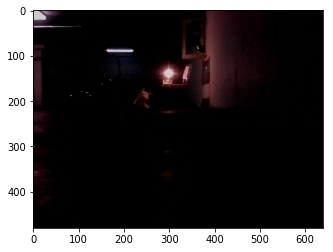

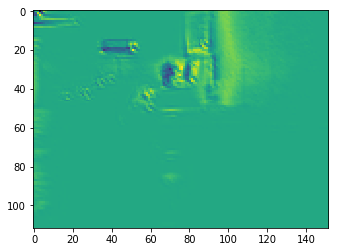

(112, 152)


In [4]:
cf_detector = CoarseFireDetector().cuda()
out = cf_detector(load_image('data/2nircent0/undistorted/276_left.jpg').cuda())
print(out.size())
plt.imshow(load_image('data/2nircent0/undistorted/276_left.jpg').numpy().transpose(1,2,0))
plt.show()
plt.imshow(out.cpu().detach().numpy())
plt.show()
print(out.cpu().detach().numpy().shape)
label_shape = out.cpu().detach().numpy().shape

In [5]:
import os
import pickle
import pprint
import random

def show_torch_img(tensor):
    plt.imshow(tensor.detach().cpu().numpy().transpose(1,2,0))
    plt.show()

pp = pprint.PrettyPrinter(indent=2)

# Training Dataset
data = "data/2nircent0"
metadp = "crpd_metadata.dat"
metadata = None
with open(os.path.join(data, metadp), 'rb') as metadf:
    metadata = pickle.load(metadf)
    #metadata = dict((k,metadata[k]) for k in range(478))
    #pp.pprint(metadata)

# load the input imgs
input_imgs = []
coords = []
for i, num in enumerate(metadata):
    input_imgs.append(load_image(metadata[num]['left']['img_path']))
    coords.append(metadata[num]['left']['coords'])
    input_imgs.append(load_image(metadata[num]['right']['img_path']))
    coords.append(metadata[num]['right']['coords'])
    #print(coords[-2])
    #show_torch_img(input_imgs[-2])
    #show_torch_img(input_imgs[-1])

indices = list(range(len(input_imgs)))
random.shuffle(indices)
print(indices)
input_imgs = [input_imgs[ind] for ind in indices]
coords = [coords[ind] for ind in indices]

[42, 32, 53, 4, 14, 9, 18, 20, 57, 36, 15, 29, 19, 13, 16, 44, 7, 21, 23, 10, 30, 41, 38, 25, 31, 47, 27, 55, 37, 2, 22, 52, 50, 26, 39, 40, 49, 0, 1, 6, 34, 46, 11, 17, 43, 24, 54, 8, 35, 33, 12, 56, 3, 5, 51, 28, 45, 48]


2D Gaussian-like array:


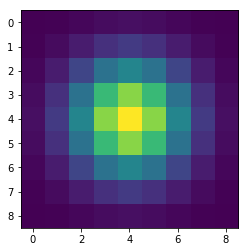

In [6]:
import numpy as np
x, y = np.meshgrid(np.linspace(-1,1,9), np.linspace(-1,1,9))
d = np.sqrt(x*x+y*y)
sigma, mu = 0.4, 0.0
g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
print("2D Gaussian-like array:")
#print(g)
plt.imshow(g)
#print(g.shape)

labels = []
for num, img in enumerate(input_imgs):
    #print(num)
    # Create labels
    #print(metadata[num])
    #print(input_imgs[num])
    label = np.zeros(label_shape)
    coord = coords[num]
    _, input_imgs_w, input_imgs_h = input_imgs[num].numpy().shape
    #print(input_imgs_w, input_imgs_h)
    #print(label_shape)
    
    #print(coord)
    central = (int(coord[0]/input_imgs_w*label_shape[0]), 
                    int(coord[1]/input_imgs_h*label_shape[1]))
    #print(central)
    #print(central)
    for i in range(-4, 5):
        for j in range(-4, 5):
            lx = min(max(central[1]+i, 0),label_shape[0]-1)
            ly = min(max(central[0]+j, 0),label_shape[1]-1)
            label[lx, ly] += g[i+4, j+4] 
    #show_torch_img(img)
    #plt.show()
    #plt.imshow(label)
    #plt.show()
    #show_torch_img
    labels.append(label)

In [7]:
from torch import FloatTensor
from torch import optim

cf_detector = CoarseFireDetector().cuda()

optimizer = optim.Adam(cf_detector.parameters(), lr = 0.001) 

n_epochs = 3
for i in range(n_epochs):
    for j, (img, label) in enumerate(zip(input_imgs, labels)):
        if j < 36:
            optimizer.zero_grad()
            out = cf_detector(img.cuda().unsqueeze(0))
            print(out.size())
            weights = np.zeros_like(label)
            weights[label<0.001] = 1.5
            weights[label>=0.001] = 1.0
            loss = torch.mean(FloatTensor(weights).cuda()*(FloatTensor(label).cuda()-out)**2)
            #loss = torch.sum((FloatTensor(label).cuda()-out)**2)
            loss.backward()
            optimizer.step()
            print(loss.item())


4
torch.Size([1, 1, 112, 152])
0.02476341277360916
4
torch.Size([1, 1, 112, 152])
0.021304743364453316
4
torch.Size([1, 1, 112, 152])
0.01750209368765354
4
torch.Size([1, 1, 112, 152])
0.013055200688540936
4
torch.Size([1, 1, 112, 152])
0.009579169563949108
4
torch.Size([1, 1, 112, 152])
0.00609496608376503
4
torch.Size([1, 1, 112, 152])
0.004280507564544678
4
torch.Size([1, 1, 112, 152])
0.002632399555295706
4
torch.Size([1, 1, 112, 152])
0.0013706538593396544
4
torch.Size([1, 1, 112, 152])
0.0024009584449231625
4
torch.Size([1, 1, 112, 152])
0.005504798609763384
4
torch.Size([1, 1, 112, 152])
0.002800913993269205
4
torch.Size([1, 1, 112, 152])
0.001360108144581318
4
torch.Size([1, 1, 112, 152])
0.0032854003366082907
4
torch.Size([1, 1, 112, 152])
0.0008670006645843387
4
torch.Size([1, 1, 112, 152])
0.0009036025148816407
4
torch.Size([1, 1, 112, 152])
0.0009515108540654182
4
torch.Size([1, 1, 112, 152])
0.0010699016274884343
4
torch.Size([1, 1, 112, 152])
0.0012381942942738533
4
torch

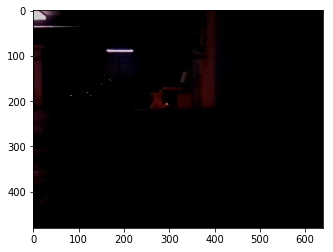

3


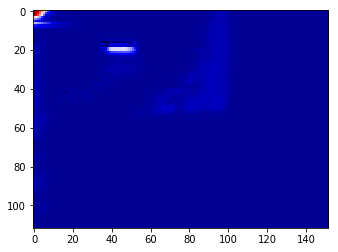

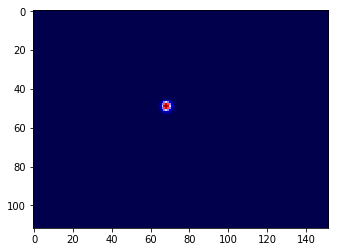

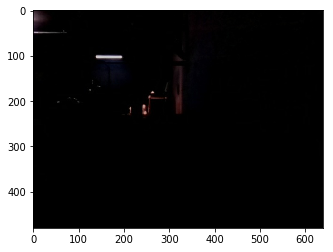

3


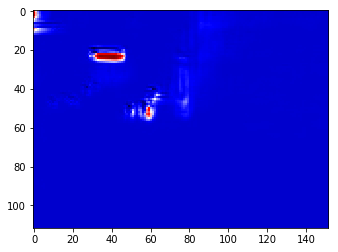

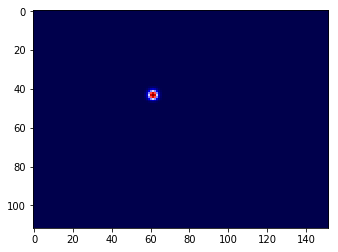

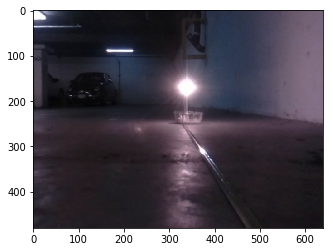

3


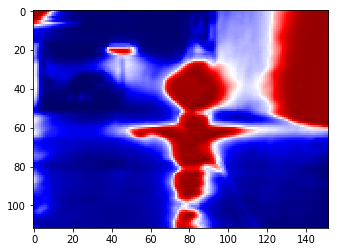

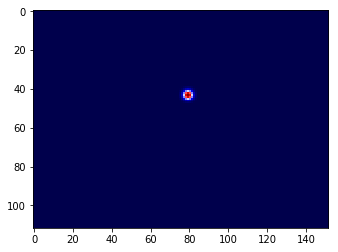

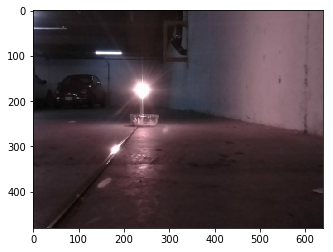

3


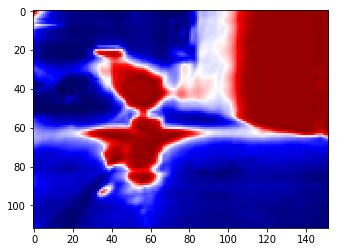

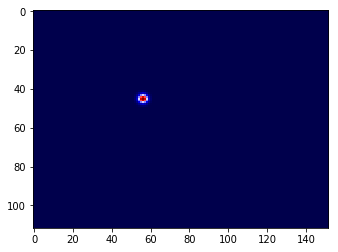

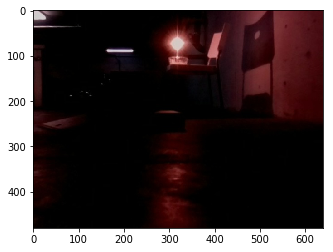

3


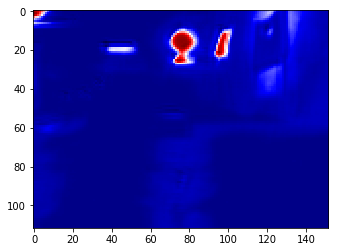

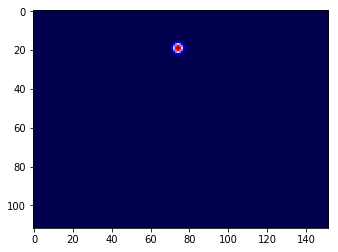

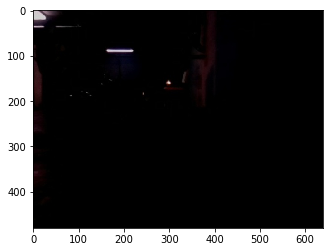

3


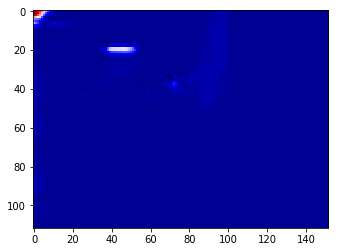

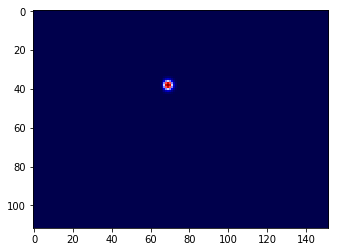

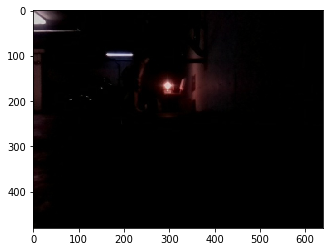

3


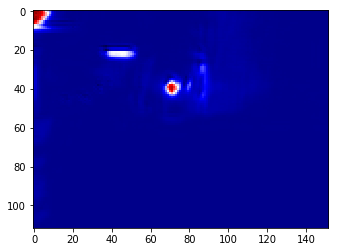

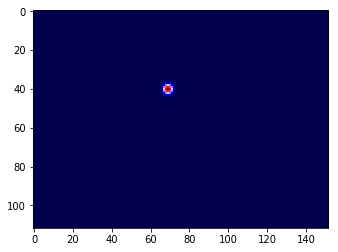

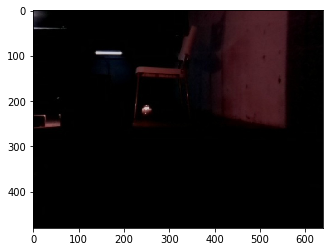

3


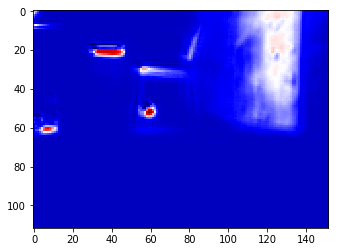

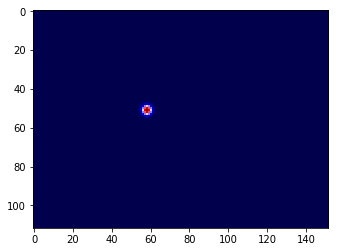

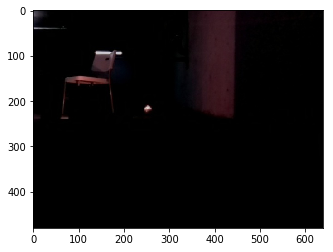

3


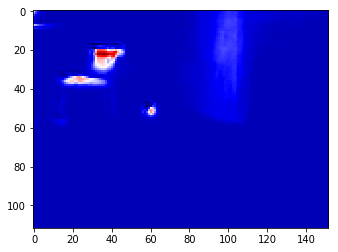

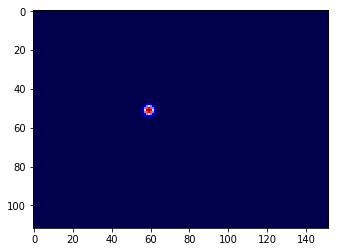

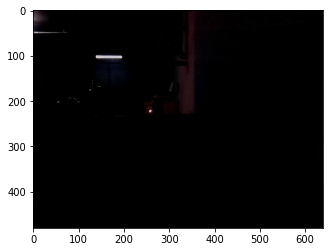

3


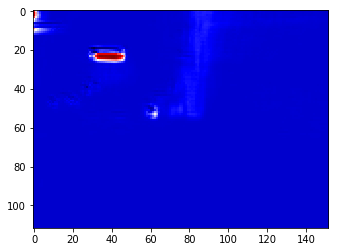

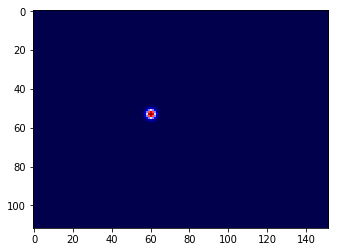

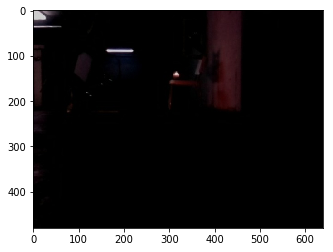

3


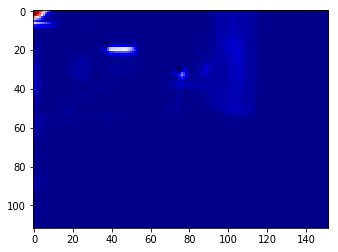

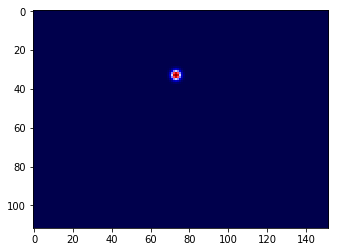

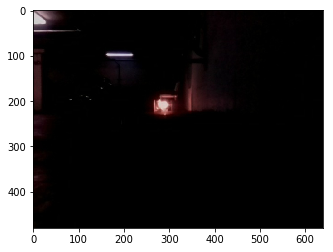

3


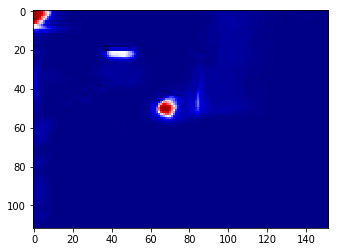

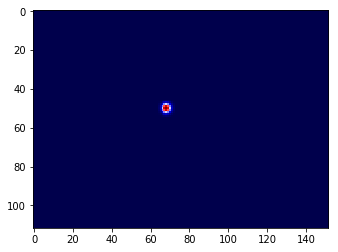

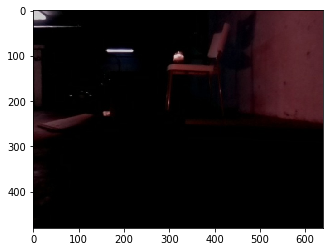

3


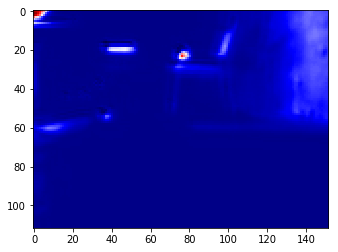

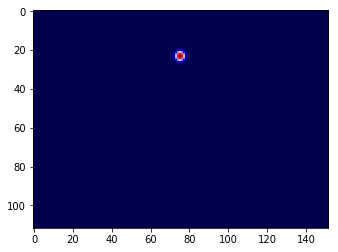

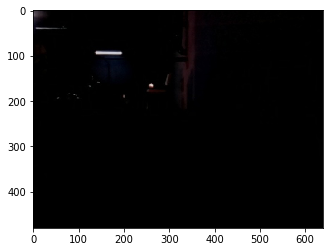

3


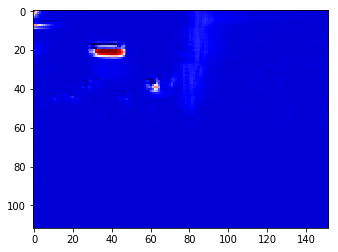

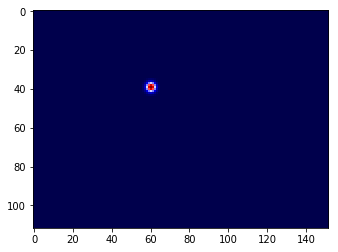

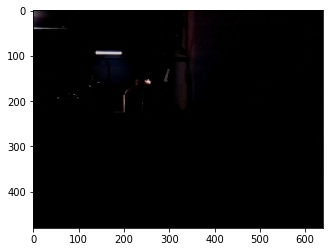

3


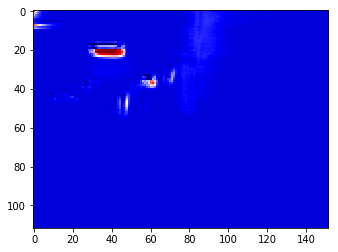

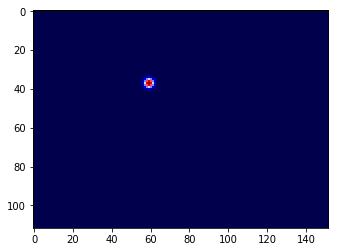

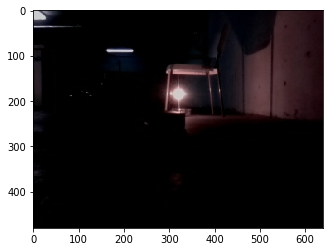

3


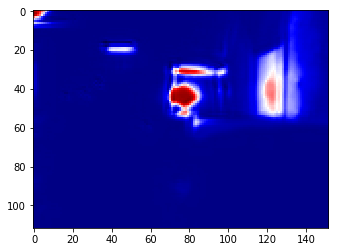

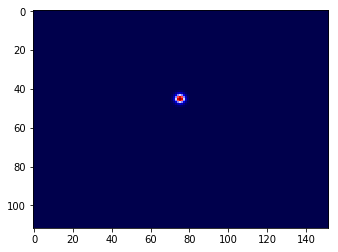

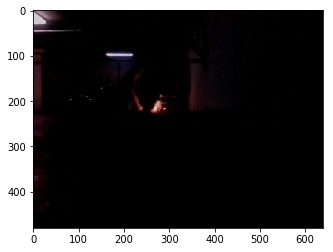

3


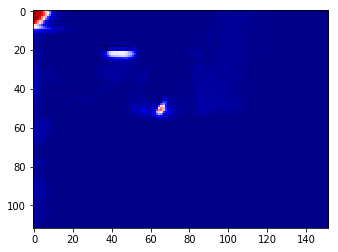

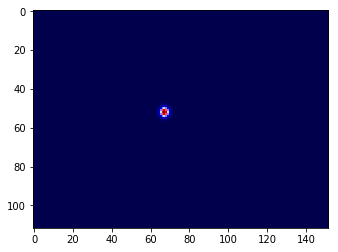

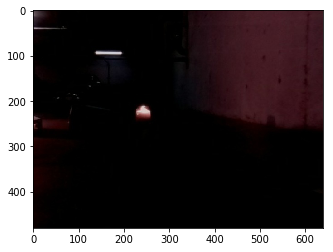

3


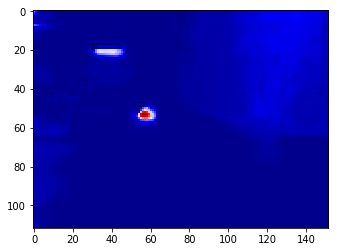

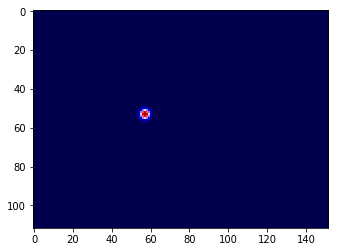

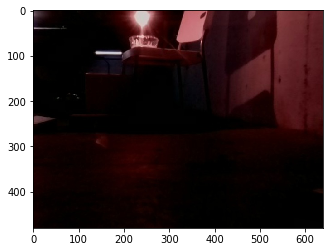

3


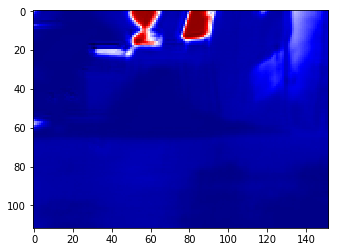

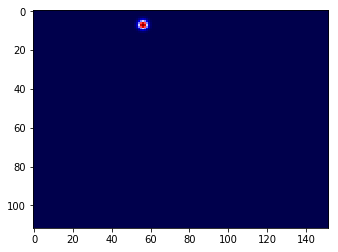

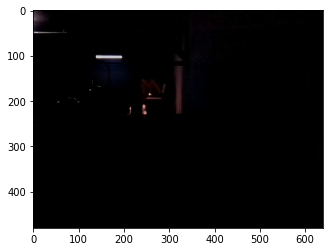

3


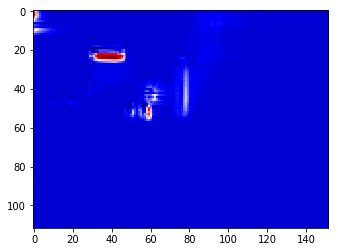

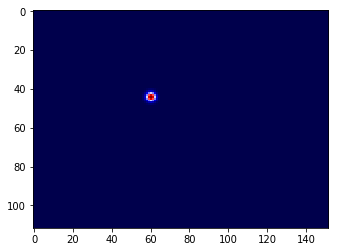

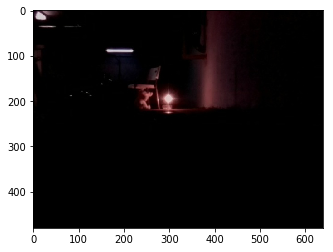

3


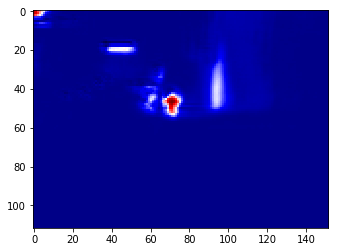

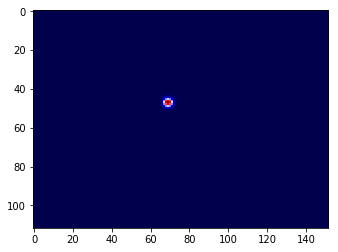

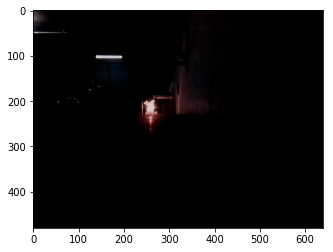

3


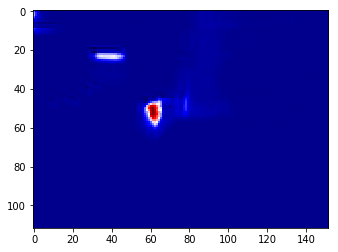

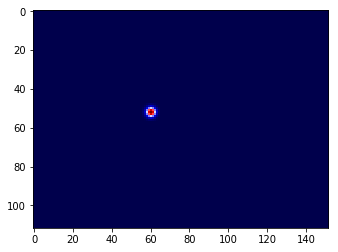

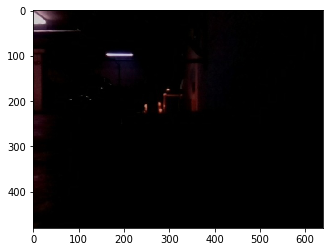

3


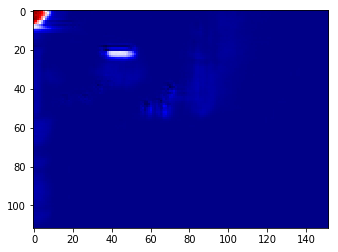

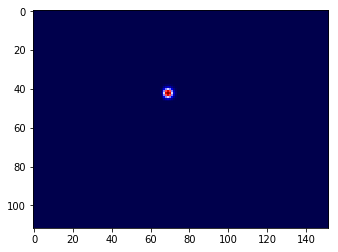

In [8]:
for ind, (img, label) in enumerate(zip(input_imgs, labels)):
    if ind >= 35:
        show_torch_img(img)
        plt.imshow(cf_detector.cuda()(img.cuda()).cpu().detach().numpy(), cmap = "seismic")
        plt.show()
        plt.imshow(label, cmap = "seismic")
        plt.show()